In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
import os
path = './Dataset/train/' 
class_names = sorted(os.listdir(path))
num_classes = len(class_names)
print (num_classes)
img_size = (192, 192, 3)

print('classes: ', class_names)

5
classes:  ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']


In [4]:
import cv2

labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')
    for img in os.listdir(path + cl):
        label = np.zeros(num_classes)
        label[class_names.index(cl)] = 1
        labels.append(label)
        
        image = np.asarray(cv2.resize(cv2.imread(path + cl + '/' + img, cv2.IMREAD_COLOR), img_size[0:2]))

        
        #image = np.asarray(cv2.resize(cv2.imread(data_path + cl + '/' + img, cv2.COLOR_BGR2RGB), img_size[0:2]))
        images.append(image)
    print('done')

    
labels = np.asarray(labels)
images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')


images:

Acne -> done
Actinic Keratosis -> done
Basal Cell Carcinoma -> done
Eczemaa -> done
Rosacea -> done


labels shape: (440, 5)
images shape: (440, 192, 192, 3)


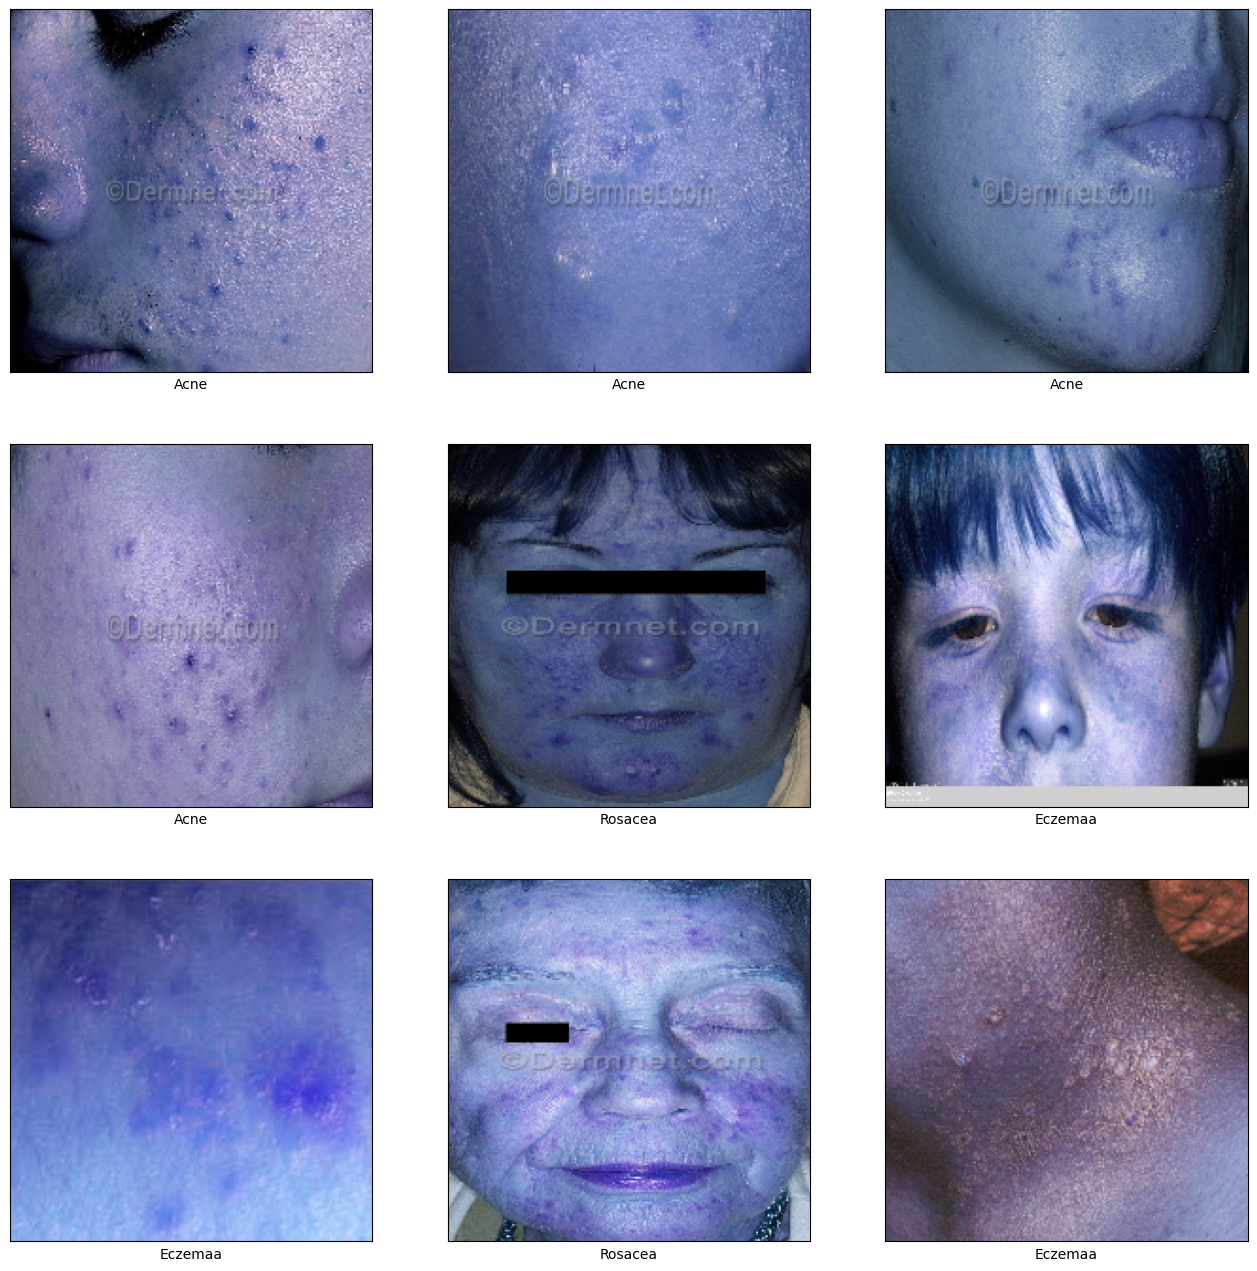

In [5]:
from random import randint

fig, axs = plt.subplots(3, 3, figsize=(16, 16))#Original was 10,6

for x in range(3):
    for y in range(3):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
                    
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
        
plt.show()

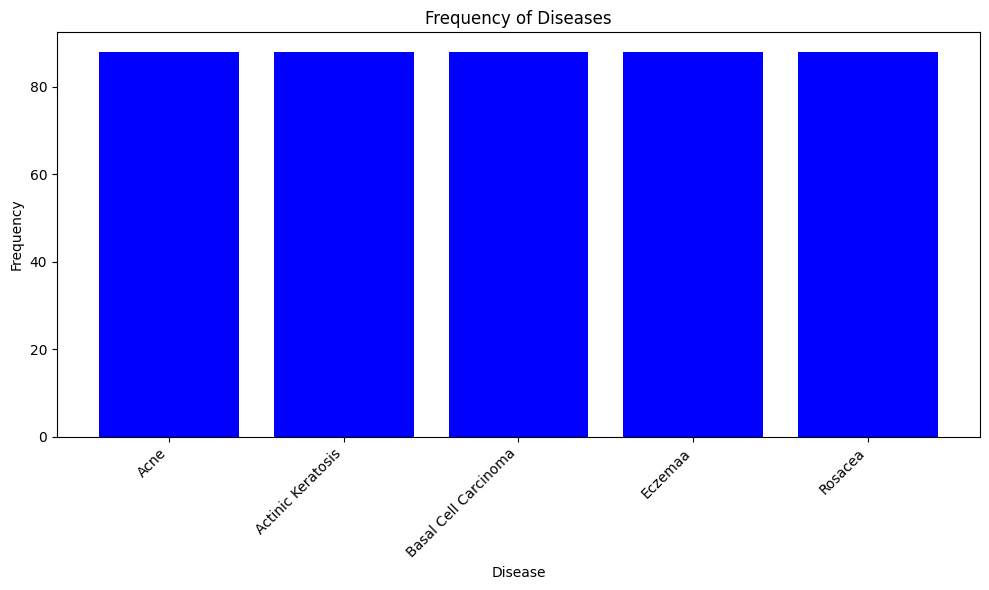

In [22]:
import matplotlib.pyplot as plt

# Chemin vers le répertoire d'entraînement
path = './Dataset/train/'  # N'oubliez pas la barre oblique finale

# Obtenez la liste des noms de classes (dossiers)
class_names = sorted(os.listdir(path))

# Comptez le nombre d'images dans chaque classe
class_counts = []
for class_name in class_names:
    class_path = os.path.join(path, class_name)
    num_images = len(os.listdir(class_path))
    class_counts.append(num_images)

# Tracé de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='blue')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Frequency of Diseases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [6]:
#r diviser vos données en ensembles d’entraînement et de validation.
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (374, 192, 192, 3)
train labels shape: (374, 5)

validation images shape: (66, 192, 192, 3)
validation labels shape: (66, 5)



In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger le modèle VGG16 pré-entraîné sans les couches fully-connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Autoriser le fine-tuning des dernières couches convolutionnelles
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Ajouter des couches fully-connected personnalisées au-dessus du modèle VGG16
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Créer un modèle composite en spécifiant les entrées et les sorties
model = Model(inputs=base_model.input, outputs=output)

# Compiler le modèle avec un taux d'apprentissage plus faible
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Augmenter les données d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Dataset/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    'Dataset/testing',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

# Entraîner le modèle avec plus d'époques
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Visualiser les performances d'entraînement
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Found 440 images belonging to 5 classes.
Found 185 images belonging to 5 classes.
Epoch 1/50


14/14 [==============================] - 42s 3s/step - loss: 1.5949 - accuracy: 0.3023 - val_loss: 1.3991 - val_accuracy: 0.3946
Epoch 2/50
 1/14 [=>............................] - ETA: 23s - loss: 1.3771 - accuracy: 0.4375

In [ ]:
#architecture
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#poids
model.save_weights('cnn_model.h5')

In [4]:
from keras.models import model_from_json

json_file = open('./cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [19]:
import cv2

# Chemin vers l'image
image_path = 'images/1.jpeg'

# Lire l'image

loaded_image = cv2.imread(image_path)


In [20]:
import numpy as np
import cv2

# Convertir l'image téléchargée en tableau numpy
uploaded_image_np = np.array(loaded_image)

# Redimensionner l'image à la taille attendue par le modèle
processed_image = cv2.resize(uploaded_image_np, (128, 128))

# Mettre à l'échelle les valeurs de pixels à l'intervalle [0, 1]
processed_image = processed_image / 255.0


In [21]:
from tensorflow.keras.models import load_model

# Charger le modèle CNN préalablement entraîné
model.load_weights("./cnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:


# Effectuer la prédiction avec le modèle
prediction = model.predict(np.expand_dims(processed_image, axis=0))

# Obtenir la classe prédite
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

print(f"Classe prédite : {predicted_class}")


1/1 [==============================] - 0s 199ms/step
Classe prédite : Acne


1/1 [==============================] - 0s 110ms/step


In [ ]:
cap.release()
cv2.destroyAllWindows()

NameError: name 'load_weights' is not defined